## Data Processing

Using data from Yahoo Finance

In [51]:
# Dependencies
import datetime as dt
import yfinance as yf

import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

In [52]:
# Define data range
company = '^FCHI'

start = dt.datetime(2015,1,1)
end = dt.datetime(2020,1,1)

In [53]:
# Load Data
data = yf.download(company, start = start, end=end)

[*********************100%%**********************]  1 of 1 completed


In [54]:
# Data info
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,4294.049805,4311.000000,4224.339844,4252.290039,4252.290039,69809300
2015-01-05,4221.990234,4276.919922,4105.450195,4111.359863,4111.359863,137887700
2015-01-06,4129.890137,4151.410156,4076.159912,4083.500000,4083.500000,130814400
2015-01-07,4111.729980,4144.950195,4080.780029,4112.729980,4112.729980,121316600
2015-01-08,4176.160156,4270.109863,4163.629883,4260.189941,4260.189941,154417100


In [55]:
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [56]:
scaled_data.shape

(1277, 1)

In [90]:
# Create features
window_size = 10
ouptut_size = 10

features = [scaled_data[i:(i + window_size), 0] for i in range(0, len(scaled_data) - window_size - ouptut_size)]
features = np.array(features)

labels = np.array([scaled_data[i:(i + ouptut_size), 0] for i in range(window_size, len(scaled_data) - ouptut_size)])

In [91]:
# Train test split
train_rng = int(features.shape[0]*0.8)
train_x = features[:train_rng]
train_y = labels[:train_rng]
test_x = features[train_rng:]
test_y = labels[train_rng:]

In [92]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((1005, 10), (1005, 10), (252, 10), (252, 10))

## Declare Model

In [93]:
# Make Kernel
kernel = DotProduct() + WhiteKernel()

In [94]:
# Make Model
model = GaussianProcessRegressor(kernel=kernel, random_state=42)

## Train Model

In [95]:
model.fit(train_x, train_y)

GaussianProcessRegressor(kernel=DotProduct(sigma_0=1) + WhiteKernel(noise_level=1),
                         random_state=42)

## Test Model

In [96]:
train_score = model.score(train_x, train_y)
test_score = model.score(test_x, test_y)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")

Train Score: 0.9148707784378438
Test Score: 0.8575369587187535


In [97]:
train_pred = model.predict(train_x)
train_pred = scaler.inverse_transform(train_pred.reshape(-1, 10))
train_pred.shape

(1005, 10)

## Plot predictions

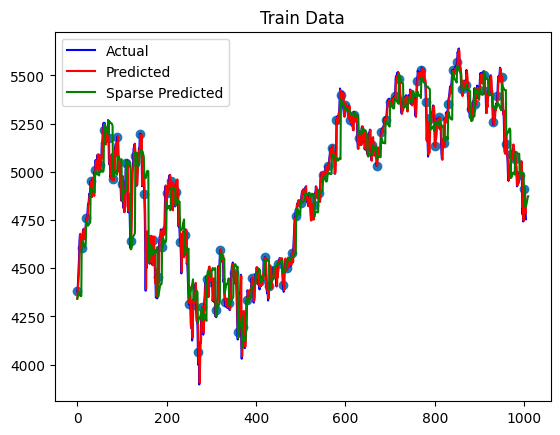

In [98]:
# Plot train results
train_pred = model.predict(train_x)
train_pred = scaler.inverse_transform(train_pred.reshape(-1, ouptut_size))
train_y_scaled = scaler.inverse_transform(train_y.reshape(-1, ouptut_size))

sparse_preds_train = np.concatenate([train_pred[i] for i in range(0, train_pred.shape[0], ouptut_size)])
real_points_train = np.array([[i, train_y_scaled[i, 0]] for i in range(0, train_y_scaled.shape[0], ouptut_size)])

plt.plot(train_y_scaled[:, 0], color='blue', label='Actual')
plt.plot(train_pred[:, 0], color='red', label='Predicted')
plt.plot(sparse_preds_train, color='green', label='Sparse Predicted')
plt.scatter(real_points_train[:, 0], real_points_train[:, 1])
plt.title('Train Data')
plt.legend()
plt.show()

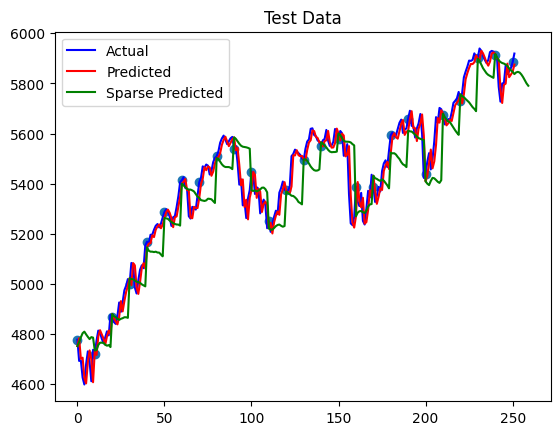

In [99]:
# Plot test results
test_pred = model.predict(test_x)
test_pred = scaler.inverse_transform(test_pred.reshape(-1, ouptut_size))
test_y_scaled = scaler.inverse_transform(test_y.reshape(-1, ouptut_size))

sparse_preds_test = np.concatenate([test_pred[i] for i in range(0, test_pred.shape[0], ouptut_size)])
real_points_test = np.array([[i, test_y_scaled[i, 0]] for i in range(0, test_y_scaled.shape[0], ouptut_size)])

plt.plot(test_y_scaled[:, 0], color='blue', label='Actual')
plt.plot(test_pred[:, 0], color='red', label='Predicted')
plt.plot(sparse_preds_test, color='green', label='Sparse Predicted')
plt.scatter(real_points_test[:, 0], real_points_test[:, 1])
plt.title('Test Data')
plt.legend()
plt.show()